# Automatic Feature Selection
Techniches to reduce the number of features and maybe avoid overfitting

## Univariate Statistics
Compute whether there is a statistically significant relationship between each feature and the target. Then the features that are related with the highest confidence are selected

In [1]:
from sklearn.datasets import load_breast_cancer
from sklearn.feature_selection import SelectPercentile
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
cancer = load_breast_cancer()
# get deterministic random numbers
rng = np.random.RandomState(42)
noise = rng.normal(size=(len(cancer.data), 50))
# add noise features to the data
# the first 30 features are from the dataset, the next 50 are noise
X_w_noise = np.hstack([cancer.data, noise])
X_train, X_test, y_train, y_test = train_test_split(
X_w_noise, cancer.target, random_state=0, test_size=.5)
# use f_classif (the default) and SelectPercentile to select 50% of features
select = SelectPercentile(percentile=50)
select.fit(X_train, y_train)
# transform training set
X_train_selected = select.transform(X_train)
print(f"X_train.shape: {X_train.shape}")
print(f"X_train_selected.shape: {X_train_selected.shape}")

X_train.shape: (284, 80)
X_train_selected.shape: (284, 40)


[ True  True  True  True  True  True  True  True  True False  True False
  True  True  True  True  True  True False False  True  True  True  True
  True  True  True  True  True  True False False False  True False  True
 False False  True False False False False  True False False  True False
 False  True False  True False False False False False False  True False
  True False False False False  True False  True False False False False
  True  True False  True False False False False]


Text(0.5, 0, 'Sample index')

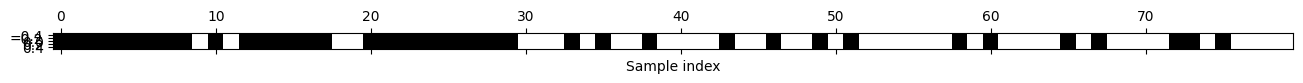

In [3]:
#Returns a Boolean mask of the selected features
mask = select.get_support()
print(mask)
# visualize the mask -- black is True, white is False
plt.matshow(mask.reshape(1, -1), cmap='gray_r')
plt.xlabel("Sample index")

#### Comparing the performance of logistic regression on all features against the performance using only the selected features

In [4]:
from sklearn.linear_model import LogisticRegression
# transform test data
X_test_selected = select.transform(X_test)
lr = LogisticRegression(max_iter=5000)
lr.fit(X_train, y_train)
print(f"Score with all features: {lr.score(X_test, y_test):.3f}")
lr.fit(X_train_selected, y_train)
print(f"Score with only selected features: {lr.score(X_test_selected, y_test):.3f}")

Score with all features: 0.951
Score with only selected features: 0.933


For high values of max_iter (>2000) the performance is better for all features.

## Model-Based Feature Selection
Use supervised machine learning model to judge the importance of each feature, and keeps only the most important ones

In [5]:
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestClassifier
#The SelectFromModel class selects all features that have an importance measure of the feature (as provided by the supervised model) greater than the provided threshold
select = SelectFromModel(RandomForestClassifier(n_estimators=100, random_state=42),threshold="median")
select.fit(X_train, y_train)
X_train_l1 = select.transform(X_train)
print(f"X_train.shape: {X_train.shape}")
print(f"X_train_l1.shape: {X_train_l1.shape}")

X_train.shape: (284, 80)
X_train_l1.shape: (284, 40)


Text(0.5, 0, 'Sample index')

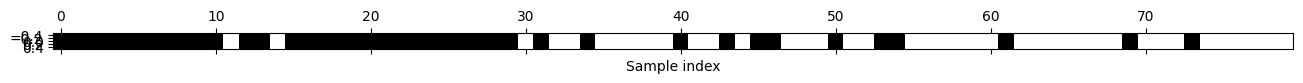

In [6]:
#Taking a look at the features selected by the RandomForestClassifier
mask = select.get_support()
# visualize the mask -- black is True, white is False
plt.matshow(mask.reshape(1, -1), cmap='gray_r')
plt.xlabel("Sample index")

In [7]:
X_test_l1 = select.transform(X_test)
score = LogisticRegression(max_iter=5000).fit(X_train_l1, y_train).score(X_test_l1, y_test)
print(f"Score with L1-based feature selection: {score:.3f}")

Score with L1-based feature selection: 0.947


## Iterative Feature Selection
In iterative feature selection, a series of models are built, with varying numbers of features.
<br>**The downside is that it slower than the other 2 mprevious methods!**

Text(0.5, 0, 'Sample index')

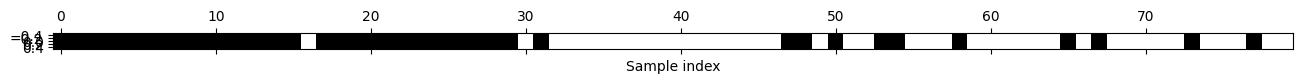

In [8]:
#The RFE is a recursive feature elimination method that fits a model and removes the weakest feature(s), until the specified number of features is reached.
from sklearn.feature_selection import RFE
select = RFE(RandomForestClassifier(n_estimators=100, random_state=42),
n_features_to_select=40)
select.fit(X_train, y_train)
# visualize the selected features:
mask = select.get_support()
plt.matshow(mask.reshape(1, -1), cmap='gray_r')
plt.xlabel("Sample index")

In [9]:
X_train_rfe= select.transform(X_train)
X_test_rfe= select.transform(X_test)
score = LogisticRegression(max_iter=5000).fit(X_train_rfe, y_train).score(X_test_rfe, y_test)
print(f"Test score: {score:.3f}")
print(f"Test score: {select.score(X_test, y_test):.3f}")

Test score: 0.940
Test score: 0.951


### Utilizing Expert Knowledge


In [11]:
import mglearn
citibike = mglearn.datasets.load_citibike()
print(f"Citi Bike data:\n{citibike.head()}")

Citi Bike data:
starttime
2015-08-01 00:00:00     3
2015-08-01 03:00:00     0
2015-08-01 06:00:00     9
2015-08-01 09:00:00    41
2015-08-01 12:00:00    39
Freq: 3h, Name: one, dtype: int64


Text(0, 0.5, 'Rentals')

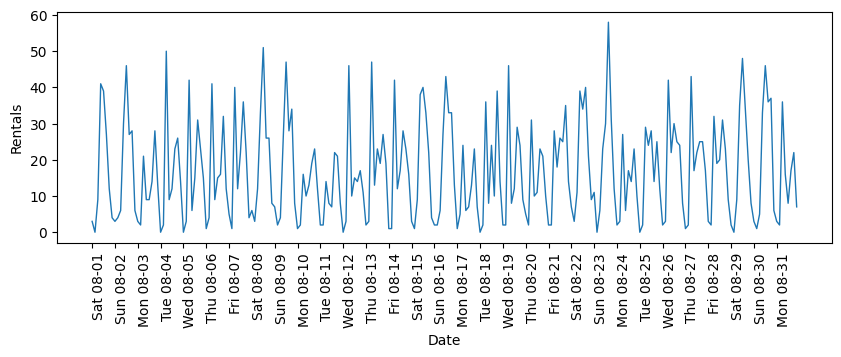

In [ ]:
plt.figure(figsize=(10, 3))
xticks = pd.date_range(start=citibike.index.min(), end=citibike.index.max(),freq='D')
plt.xticks(xticks, xticks.strftime("%a %m-%d"), rotation=90, ha="left")
plt.plot(citibike, linewidth=1)
plt.xlabel("Date")
plt.ylabel("Rentals")

In [20]:
# extract the target values (number of rentals)
# Define target (rentals)
y = citibike.values

# Define features (convert datetime index to ordinal numbers)
X = citibike.index.astype("int64").values.reshape(-1, 1)  # int64 for UNIX timestamps
# use the first 184 data points for training, and the rest for testing
n_train = 184
# function to evaluate and plot a regressor on a given feature set
def eval_on_features(features, target, regressor):
    # split the given features into a training and a test set
    X_train, X_test = features[:n_train], features[n_train:]
    # also split the target array
    y_train, y_test = target[:n_train], target[n_train:]
    regressor.fit(X_train, y_train)
    print(f"Test-set R^2: {regressor.score(X_test, y_test):.2f}")
    y_pred = regressor.predict(X_test)
    y_pred_train = regressor.predict(X_train)
    plt.figure(figsize=(10, 3))
    plt.xticks(range(0, len(X), 8), xticks.strftime("%a %m-%d"), rotation=90,ha="left")
    plt.plot(range(n_train), y_train, label="train")
    plt.plot(range(n_train, len(y_test) + n_train), y_test, '-', label="test")
    plt.plot(range(n_train), y_pred_train, '--', label="prediction train")
    plt.plot(range(n_train, len(y_test) + n_train), y_pred, '--',label="prediction test")
    plt.legend(loc=(1.01, 0))
    plt.xlabel("Date")
    plt.ylabel("Rentals")

Test-set R^2: -0.04


<Figure size 640x480 with 0 Axes>

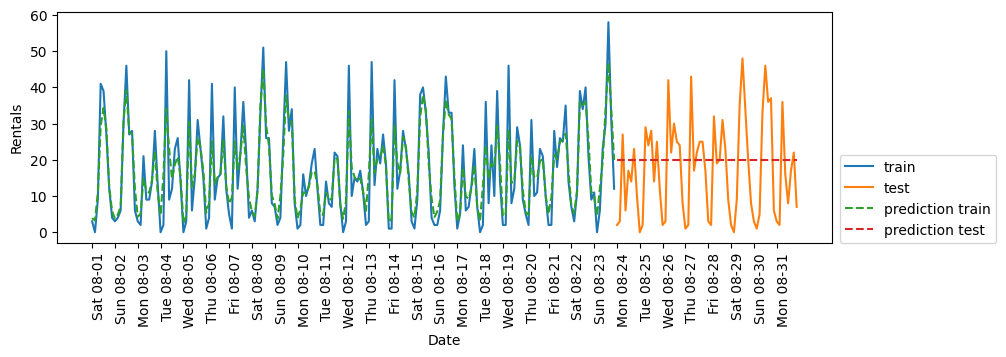

In [18]:
from sklearn.ensemble import RandomForestRegressor
regressor = RandomForestRegressor(n_estimators=100, random_state=0)
plt.figure()

eval_on_features(X, y, regressor)

In [ ]:

X_hour = citibike.index.hour.to_numpy().reshape(-1, 1)
X_dayofweek = citibike.index.dayofweek.to_numpy().reshape(-1, 1)

# Combine day of week and hour
X_hour_week = np.hstack([X_dayofweek, X_hour])

In [25]:
from sklearn.preprocessing import OneHotEncoder

enc = OneHotEncoder()
X_hour_week_onehot = enc.fit_transform(X_hour_week).toarray()

Test-set R^2: 0.84


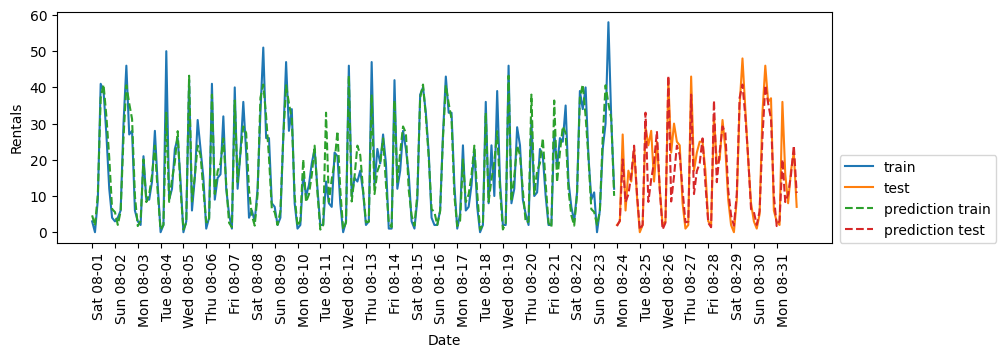

In [26]:
eval_on_features(X_hour_week_onehot, y, regressor)

Test-set R^2: 0.13


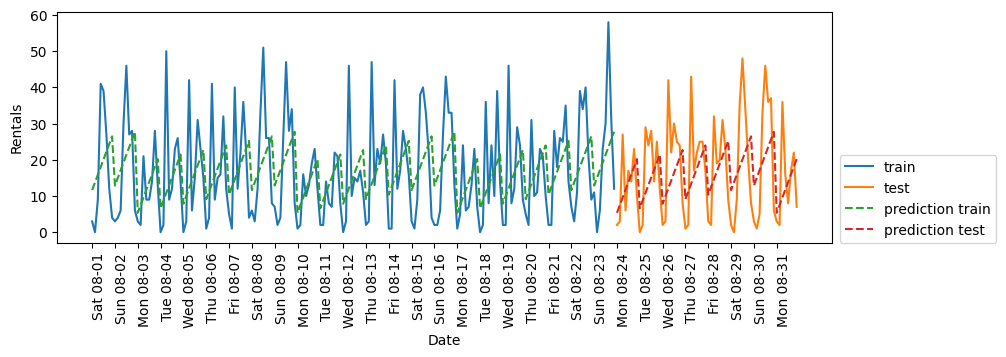

In [27]:
from sklearn.linear_model import LinearRegression
eval_on_features(X_hour_week, y, LinearRegression())

Test-set R^2: 0.62


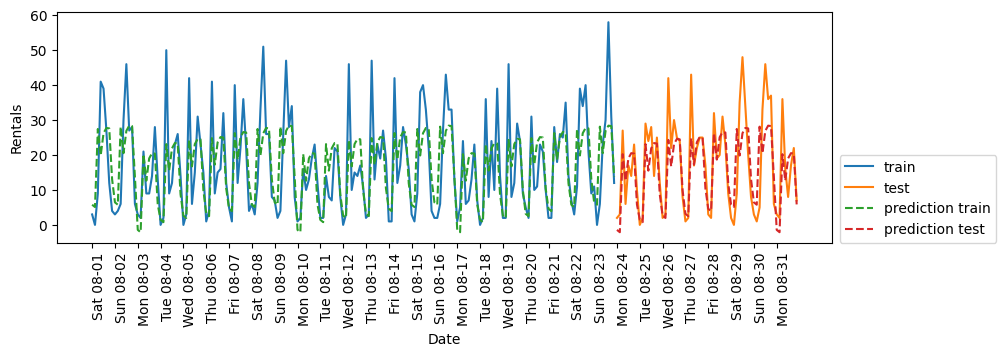

In [29]:
#Ridge
from sklearn.linear_model import Ridge
enc = OneHotEncoder()
X_hour_week_onehot = enc.fit_transform(X_hour_week).toarray()
eval_on_features(X_hour_week_onehot, y, Ridge())

Test-set R^2: 0.85


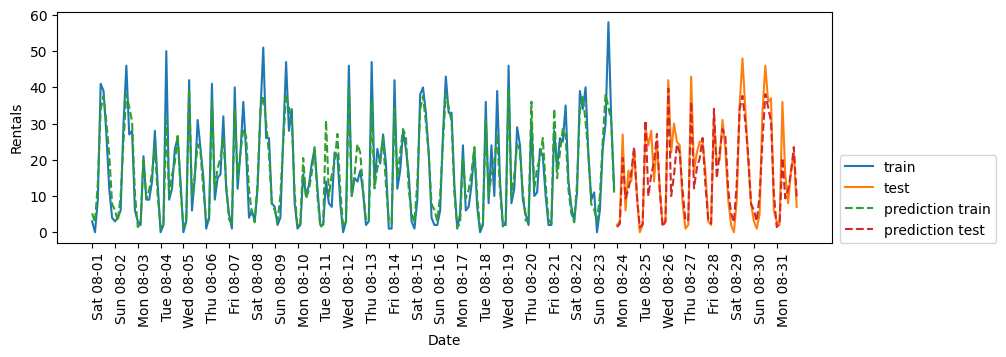

In [31]:
#poly_transformer
from sklearn.preprocessing import PolynomialFeatures
poly_transformer = PolynomialFeatures(degree=2, interaction_only=True,
include_bias=False)
X_hour_week_onehot_poly = poly_transformer.fit_transform(X_hour_week_onehot)
lr = Ridge()
eval_on_features(X_hour_week_onehot_poly, y, lr)
